In [125]:
import json
import re
import time
import random
from datetime import datetime
import numpy as np
from PIL import Image,ImageOps
import os
from IPython.display import display, clear_output
from IPython.display import Image as _Imgdis
from pprint import pprint
from sklearn.utils import shuffle
import h5py
import matplotlib.pyplot as plt
import shutil  
import pandas as pd

In [2]:
def get_score(value):
    distribution = np.logspace(-1,1,num=10,base=2.5)
    idx = (np.abs(distribution - value)).argmin()
    return idx+1

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
def timestamp_to_date(timestmap):
    return datetime.utcfromtimestamp(timestmap).strftime("%Y-%m-%d %H:%M:%S")

In [120]:
def get_photos_info(profile, bins = 10):    
    current_time = time.time()
    photos_in_averaging = 10
    with open('../scrap_data/{}/{}.json'.format(profile,profile)) as f:
        d = json.load(f)
    images = d['GraphImages']
    pattern = "[0-9_]*_n.jpg"
    images_info = dict(photos=[])
    for image in images:
        if len(re.findall(pattern,image['urls'][0]))==0:
            continue
        images_info['photos'].append(dict(file = re.search(pattern,image['urls'][0]).group(),
                                         likes = image['edge_media_preview_like']['count'],
                                          tags = [tag.lower() for tag in image['tags']] if 'tags' in image.keys() else [],
                                         timestamp = image['taken_at_timestamp'],
                                         date = timestamp_to_date(image['taken_at_timestamp'])))

    
    images_info = sorted(images_info['photos'],key=lambda k: k['timestamp'])
    
    expected_score = [None]*photos_in_averaging \
                     +list(running_mean([im['likes'] for im in images_info[:-1]],photos_in_averaging))
    
    for idx,image in enumerate(images_info):
        image.update({"expected":"{}".format(expected_score[idx])})


    result = list(filter(lambda im:im['expected']!='None' and current_time-im['timestamp']>3600*24,images_info))

    
    
    for image in result:
        ratio = image['likes']/float(image['expected'])
        image.update({"ratio":"{}".format(ratio)})
        image.update({"score":get_score(ratio)})
        
    expected_scores_sorted = sorted([im['ratio'] for im in result])
    
    for image in result:
        image.update({"relative_score":int((expected_scores_sorted.index(image['ratio']))/(len(result)/bins))+1})
    return result

In [111]:
#profile = "shainblumphotography"
profile ="arturstanisz"
pattern = "[0-9_]*_n.jpg"
result = get_photos_info(profile)

Working with 128 images
Image example: 


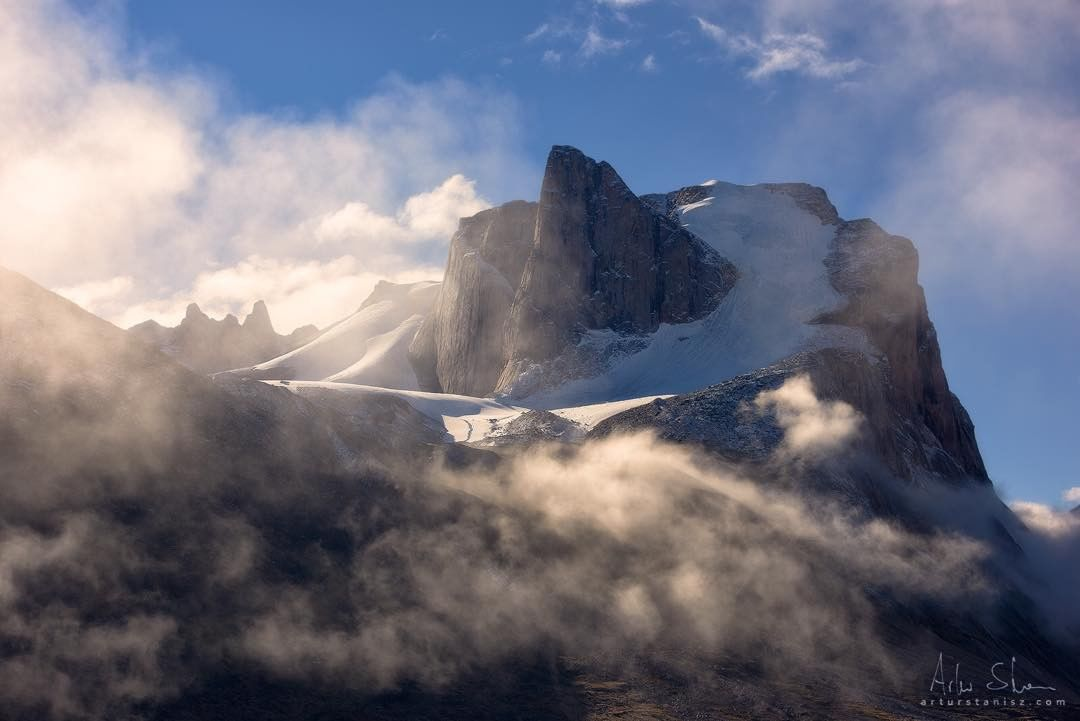

{'date': '2017-01-31 06:26:35',
 'expected': '1990.7',
 'file': '16230402_1784322685226459_9009864110149468160_n.jpg',
 'likes': 1888,
 'ratio': '0.9484101069975386',
 'relative_score': 5,
 'score': 5,
 'tags': ['iglightshots',
          'discoverearth',
          'igworldclub',
          'natgeo',
          'vega',
          'awesome_earthpix',
          'arteobjetiva',
          'landscapesofinstagram',
          'instaworld_love',
          'parkscanada',
          'phototag_it',
          'digitalarmy',
          'explorecanada',
          'earthofficial',
          'marvelshots',
          'igs_america',
          'tentree',
          'ig_wildplace',
          'enjoycanada',
          'instagood',
          'loves_mountains',
          'natgeotravel',
          'earthpix',
          'travel_shotz',
          'allnatureshots',
          'ventureout',
          'ig_heartshot',
          'nature',
          'worldshotz',
          'baffinisland'],
 'timestamp': 1485843995}


In [106]:
folder = "../scrap_data/"+profile

#onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.endswith(".jpg")]
onlyfiles = [im['file'] for im in result]

#file = onlyfiles[-3]
file = onlyfiles[random.randrange(len(onlyfiles))]
print("Working with {0} images".format(len(onlyfiles)))
print("Image example: ")


display(_Imgdis(filename=folder + "/" + file , width=240, height=320))
pprint(list(filter(lambda im:im['file']==file, result))[0])

In [8]:
def get_data(profile):
    result = get_photos_info(profile)
    onlyfiles = [im['file'] for im in result]
    folder = "../scrap_data/"+profile
    dataset = np.ndarray(dtype='int8',shape=(len(onlyfiles),224,224,3))
    labels = np.ndarray(shape=(len(onlyfiles),2))
    wrong_indices = []
    for idx,im in enumerate(result):
        if idx%50 == 0:
            print("Progress: {}%".format(idx/len(onlyfiles)))
        try:
            original_image = Image.open(folder+"/"+im['file'])
            dataset[idx] = np.array(ImageOps.fit(original_image, (224, 224), Image.ANTIALIAS))
            labels[idx] = [im['ratio'],im['relative_score']]
        except OSError as e:
            wrong_indices.append(idx)
            print("Error at Index:{}".format(idx))
    return np.delete(dataset,wrong_indices,0),np.delete(labels,wrong_indices,0)

In [9]:
#%time dataset,labels = get_data(profile)

In [10]:
# photo_idx = random.randrange(len(labels))
# worst_photo_index = (np.squeeze(np.where(labels == min(labels))))
# best_photo_index = (np.squeeze(np.where(labels == max(labels))))

# Image.fromarray(dataset[photo_idx].astype('uint8'))

# print("Random photo score: {}".format(labels[photo_idx]))

# print("Worst photo score: {}".format(labels[worst_photo_index]))
# Image.fromarray(dataset[worst_photo_index].astype('uint8'))

# print("Best photo score: {}".format(labels[best_photo_index]))
# Image.fromarray(dataset[best_photo_index].astype('uint8'))

In [11]:
# path_to_scrap_data = "../scrap_data/"
# path_to_input_data = "../input_data/"
# pattern = "[0-9_]*_n.jpg"
# photos_counter = 0
# photographers_list = [f for f in os.listdir(path_to_scrap_data) if not os.path.isfile(os.path.join(path_to_scrap_data, f))]
# already_processed = [f[:-5] for f in os.listdir(path_to_input_data) if f.endswith(".hdf5")]
# photographers_list = list(set(photographers_list) - set(already_processed) - set(['storyofsage']))
# for photographer in photographers_list:
#     print("Current photographer: {}...".format(photographer))
#     result = get_photos_info(photographer)
#     dataset,labels = get_data(photographer)
#     dataset,labels = shuffle(dataset,labels,random_state = 1)
#     with h5py.File("{}{}.hdf5".format(path_to_input_data,photographer), "w") as f:
#         f.create_dataset("data", data = dataset)
#         f.create_dataset("labels", data = labels[:,0])
#         f.create_dataset("scores", data = labels[:,1])
#     photos_counter+=dataset.shape[0]
#     clear_output()
#     print("Done with photographer: {}. \nTotal # of saved photos: {}\n".format(photographer,photos_counter))
#     del dataset
#     del labels

In [75]:
def choose_set(train = 0.95, val = 0.975):
    chance = random.random()
    if chance < train:
        return "train/"
    if chance < val:
        return "val/"
    return "test/"

In [76]:
def move_to_bins(profile, output_path):
    result = get_photos_info(profile)
    onlyfiles = [im['file'] for im in result]
    folder = "../scrap_data/"+profile
    wrong_indices = []
    for idx,im in enumerate(result):
        chosed = choose_set()
        if idx%50 == 0:
            print("Progress: {}%".format(idx/len(onlyfiles)))
        try:
            path = output_path+chosed+str(int(float(im['ratio'])*100))
            Image.open(folder+"/"+im['file'])
            if not os.path.exists(path):
                os.mkdir(path)
            shutil.copyfile(folder+"/"+im['file'],path+"/"+im['file'])
        except OSError as e:
            wrong_indices.append(idx)
            print("Error at Index:{}".format(idx))
    return len(onlyfiles)

In [77]:
path_to_scrap_data = "../scrap_data/"
path_to_output_data = "../images_in_bins/"
photos_counter = 0
photographers_list = [f for f in os.listdir(path_to_scrap_data) if not os.path.isfile(os.path.join(path_to_scrap_data, f)) and not f.startswith(".")]
for photographer in photographers_list:
    print("Current photographer: {}...".format(photographer))
    length = move_to_bins(photographer,path_to_output_data)
    photos_counter += length
    clear_output()
    print("Done with photographer: {}. \nTotal # of saved photos: {}\n".format(photographer,photos_counter))

Done with photographer: hansgunnaraslaksen. 
Total # of saved photos: 30720



In [138]:
path_to_scrap_data = "../scrap_data/"
unique_tags = []
photographers_list = [f for f in os.listdir(path_to_scrap_data) if not os.path.isfile(os.path.join(path_to_scrap_data, f)) and not f.startswith(".")]
for photographer in photographers_list:
    print("Current photographer: {}...".format(photographer))
    result = get_photos_info(photographer)
    temp_tags = []
    for im in result:
        temp_tags += im['tags']
    unique_tags += list(set(temp_tags))
    clear_output()

In [149]:
path_to_scrap_data = "../scrap_data/"
tags = []
photographers_list = [f for f in os.listdir(path_to_scrap_data) if not os.path.isfile(os.path.join(path_to_scrap_data, f)) and not f.startswith(".")]
for photographer in photographers_list:
    print("Current photographer: {}...".format(photographer))
    result = get_photos_info(photographer)
    for im in result:
        tags += im['tags']
    clear_output()

In [150]:
df = pd.DataFrame(unique_tags)
df_full = pd.DataFrame(tags)

In [156]:
df[0].value_counts()[:100].index

Index(['earthpix', 'earthofficial', 'beautifuldestinations', 'artofvisuals',
       'discoverearth', 'ourplanetdaily', 'earthfocus', 'winter', 'iceland',
       'sunset', 'awesomeearth', 'sponsored', 'ad', 'awesome_earthpix',
       'nature', 'wonderful_places', 'theglobewanderer', 'main_vision',
       'landscape', 'mountains', 'autumn', 'exploretocreate',
       'jaw_dropping_shots', 'wildernessculture', 'neverstopexploring',
       'sunrise', 'moodygrams', 'travel', 'nakedplanet', 'waterfall',
       'nightphotography', 'roamtheplanet', 'longexposure', 'agameoftones',
       'dolomites', 'canada', 'norway', 'longexpoelite', 'snow',
       'stayandwander', 'fantastic_earth', 'natgeo', 'awesomeglobe',
       'landscape_captures', 'welivetoexplore', 'greatnorthcollective',
       'instagood', 'master_shots', 'ig_bliss', 'reflection',
       'watchthisinstagood', 'italy', 'milkyway', 'nikon', 'hubs_united',
       'special_shots', 'travelstoke', 'longexposure_shots', 'ig_shotz',
       

In [157]:
df_f[0].value_counts()

earthfocus               1844
discoverearth            1419
earthpix                 1405
fantastic_earth          1391
earthofficial            1324
awesome_earthpix         1238
awesomeglobe             1222
ourplanetdaily           1183
artofvisuals             1179
modernoutdoors            985
folkscenery               962
beautifuldestinations     915
roamtheplanet             904
awesomeearth              888
greatnorthcollective      852
theweekoninstagram        836
main_vision               833
nature                    806
moodygrams                796
wildlifeplanet            772
master_shots              756
diewocheaufinstagram      741
awesomedreamplaces        727
rural_love                725
vzcomood                  720
rsa_fog                   719
exploretocreate           714
tv_foggy                  705
wonderfulglobe            698
agameoftones              690
                         ... 
nikkor70_200mm              1
mountagung                  1
onelove   